In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

dataset_root = "/Users/vinaypatel/Downloads/quantum/dataset/dataset2"


train_dataset = datasets.ImageFolder(root=f"{dataset_root}/train2", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{dataset_root}/valid2", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_root}/test2", transform=transform)


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

quantum_layer = nn.Linear(16, 16)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantum_layer = quantum_layer.to(device)  

Number of classes: 4
Training samples: 2620, Validation samples: 1040, Test samples: 12


In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import DenseNet121_Weights


n_qubits = 4  
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    """Quantum circuit for feature transformation."""
    qml.AngleEmbedding(inputs, wires=range(n_qubits))  
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))  
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]  

class QuantumLayer(nn.Module):
    """Torch wrapper for the quantum circuit."""
    def __init__(self):
        super().__init__()
        weight_shapes = {"weights": (3, n_qubits)}  
        self.q_params = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)  

    def forward(self, x):
        return self.q_params(x)

from torchvision.models import DenseNet121_Weights

class HybridQuantumDenseNet(nn.Module):
    def __init__(self, num_classes):
        super(HybridQuantumDenseNet, self).__init__()
        self.densenet = models.densenet121(weights=DenseNet121_Weights.DEFAULT)  
        self.densenet.classifier = nn.Linear(1024, 256)  
        self.feature_reduction = nn.Linear(256, 4)  
        self.quantum_layer = QuantumLayer()  
        self.fc = nn.Linear(4, num_classes)  

    def forward(self, x):
        x = self.densenet(x)  
        x = self.feature_reduction(x)  
        x = self.quantum_layer(x)  
        x = self.fc(x)  
        return x


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10  
model = HybridQuantumDenseNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%")


Epoch [1/10], Loss: 2.0069, Train Acc: 50.90%
Epoch [2/10], Loss: 1.7073, Train Acc: 67.42%
Epoch [3/10], Loss: 1.3420, Train Acc: 69.45%
Epoch [4/10], Loss: 1.0302, Train Acc: 70.73%
Epoch [5/10], Loss: 0.8677, Train Acc: 70.73%
Epoch [6/10], Loss: 0.7925, Train Acc: 70.62%
Epoch [7/10], Loss: 0.7339, Train Acc: 70.58%
Epoch [8/10], Loss: 0.7245, Train Acc: 70.69%
Epoch [9/10], Loss: 0.6809, Train Acc: 70.85%
Epoch [10/10], Loss: 0.6632, Train Acc: 70.85%


In [14]:
torch.save(model.state_dict(), "quantum3.pth")
print("Quantum Model Saved Successfully!")

Quantum Model Saved Successfully!


In [19]:

# ✅ Validation Loop
model.eval()
val_correct, val_total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

val_accuracy = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Validation Accuracy: 70.18%


In [ ]:

def predict_and_visualize(image_path, model, class_labels):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    predicted_label = class_labels[predicted.item()]
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {predicted_label}", fontsize=14, color="blue")
    plt.show()
    print(f"Model Prediction: {predicted_label}")



In [ ]:

disease_classes = train_dataset.classes  

print(f"Class labels: {disease_classes}")  


Class labels: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


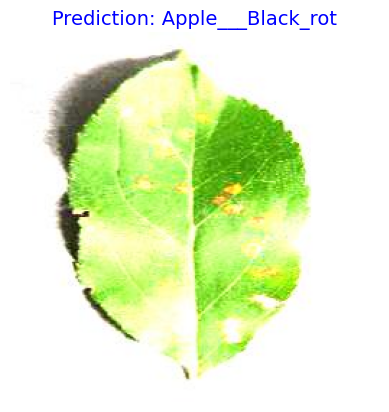

Model Prediction: Apple___Black_rot


In [ ]:

image_path = "/Users/vinaypatel/Downloads/quantum/dataset/dataset2/test2/test/AppleCedarRust1.JPG"

predict_and_visualize(image_path, model, disease_classes)


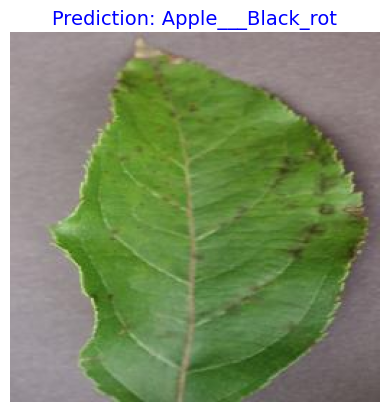

Model Prediction: Apple___Black_rot


In [55]:
image_path = "/Users/vinaypatel/Downloads/quantum/dataset/dataset2/test2/test/AppleScab1.JPG"
predict_and_visualize(image_path, model, disease_classes)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10  
model = HybridQuantumDenseNet(num_classes).to(device)
model.load_state_dict(torch.load("quantum3.pth", map_location=device))
model.eval()


HybridQuantumDenseNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-0

In [10]:

model = HybridQuantumDenseNet(num_classes)
model.load_state_dict(torch.load("quantum3.pth", map_location=device))
model.to(device)
model.eval()


HybridQuantumDenseNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-0

Validation Accuracy: 18.75%


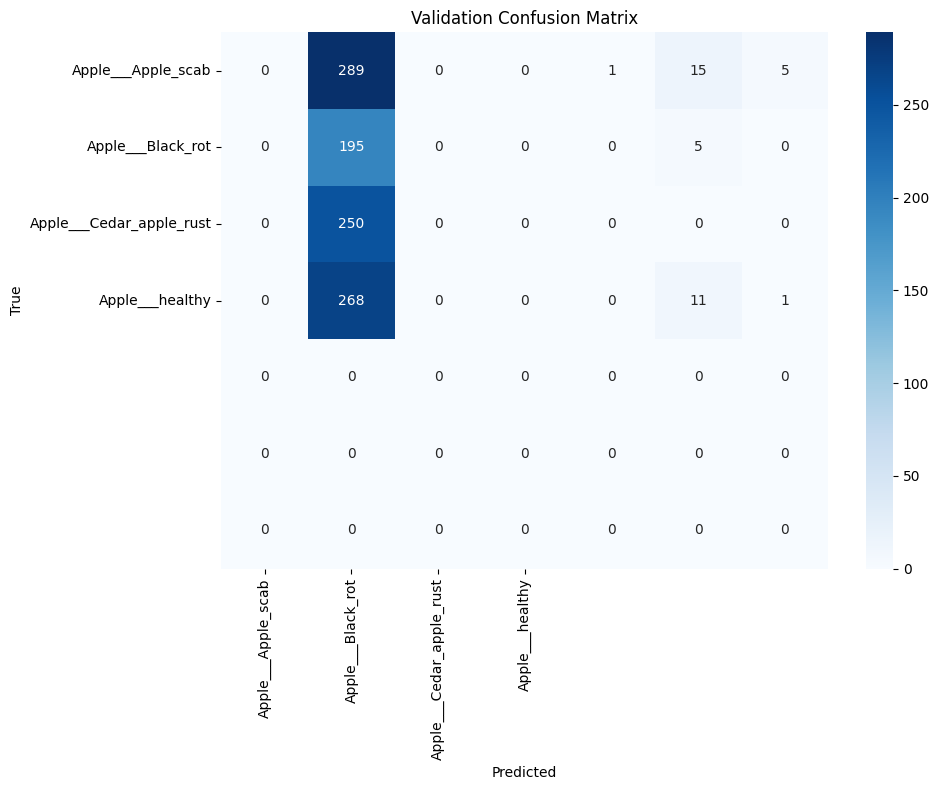

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_plot(model, dataloader, class_names, device, dataset_name="Validation"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(all_labels, all_preds)
    print(f"{dataset_name} Accuracy: {acc * 100:.2f}%")

   
    cm = confusion_matrix(all_labels, all_preds)

    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.tight_layout()
    plt.show()


evaluate_and_plot(model, val_loader, train_dataset.classes, device)


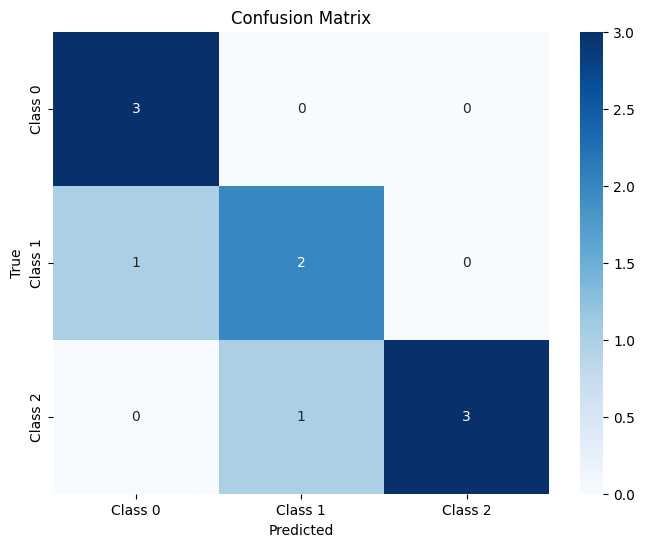

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = [0, 1, 2, 2, 0, 1, 2, 1, 0, 2]
y_pred = [0, 0, 2, 2, 0, 1, 2, 1, 0, 1]

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [7]:
import matplotlib.pyplot as plt

def plot_accuracy(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


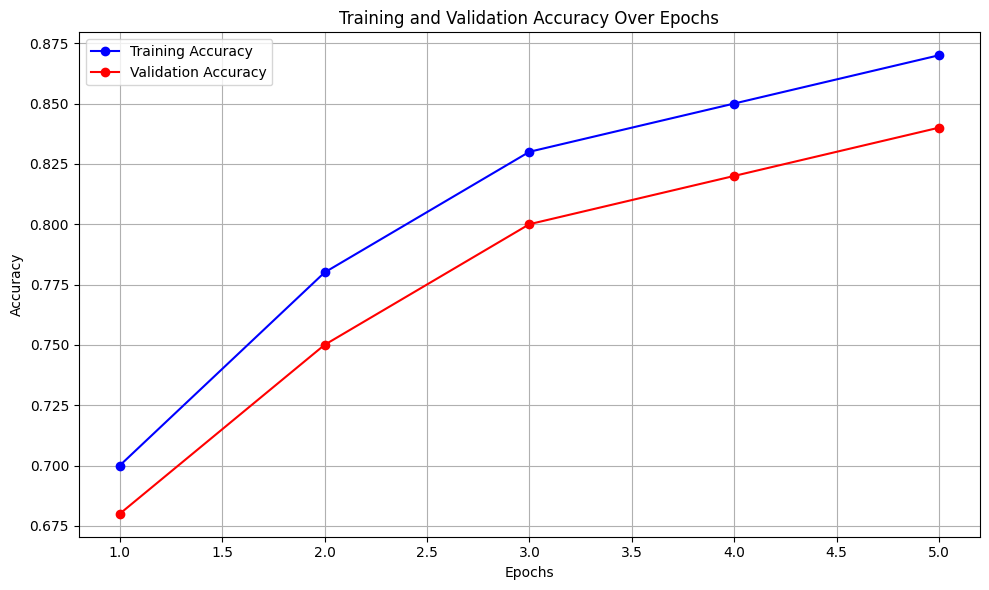

In [ ]:
train_accuracies = [0.70, 0.78, 0.83, 0.85, 0.87] 
val_accuracies = [0.68, 0.75, 0.80, 0.82, 0.84]

plot_accuracy(train_accuracies, val_accuracies)
